# 5.3 사전 훈련된 컨브넷 사용하기

### 사전 훈련된 네트워크(pretrained network)
- pretrained network는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련된 네트워크를 뜻함
- pretrained network를 사용하는 것은 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 효과적인 방법


- **일반적이고 충분히 큰 데이터셋에 훈련된 네트워크의 특성 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있음**
- 위와 같은 유연성은 얕은 학습과 비교해서 딥러닝의 핵심 장점이라고 할 수 있음
- 이런 특성은 완전히 다른 클래스의 경우라도 많은 컴퓨터 비전 문제에서 유용함


- 여기서는 ImageNet 데이터셋으로 학습된 VGG16 모델을 사용
    - ImageNet Dataset은 1400만개의 이미지와 1000개의 class를 가짐
    - VGG16 말고도 다른 많은 모델들에도 적용이 가능하지만 간단해서 사용
    

## Pretrained network 사용 방법 2가지
    1. 특성 추출(Feature Extraction)
    2. 미세 조정(Fine Tuning)

## 5.3.1 특성 추출 (Feature Extraction)

### 특성 추출
- 특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플의 특성을 뽑아내는 것


### Convnet의 특성 추출
- Convnet의 구성
    - 합성곱 기반 층
        - Convolutional layer
        - Pooling layer
    - 완전 연결 분류기
        - Fully connected layer


- 1번째 합성곱 기반 층은 동결시킨 후 재사용
- 2번째 완전 연결 분류기는 새로 학습시킴
- 따라서 **동결된 합성곱 기반 층의 출력을 이용해 2번째 완전 연결 분류기를 새로 학습시키는 방식**


### 합성곱 층만 재사용 하는 이유
- **합성곱 층에 의해 학습된 표현이 더 일반적이므로** 여러 컴퓨터비전 문제에서 유용하게 사용 가능함
- convnet의 feature map은 사진에 대해 일반적인 컨셉의 존재 여부를 기록한 맵임
- **완전 연결 층은 어떤 클래스가 존재할 확률에 관한 정보만 담고있으므로 클래스가 겹치지 않는 경우에는 재사용 하지 않음**
- 참고) ImageNet에는 고양이와 강아지가 있어서 완전 연결 층도 재사용하는 것이 더 도움이 되지만 새로운 문제의 클래스가 원본 모델의 클래스와 겹치지 않는 일반적인 경우를 다루기 위해 사용하지 않았음


### 합성곱 층의 추출 정도
- **합성곱 층에서 추출한 표현의 일반성(재사용성)은 모델 층의 깊이에 달려있음**
- 모델의 **하위 층은 지역적(엣지, 색깔, 질감 등)이고 일반적인 특성맵**으로 구성됨
- 모델의 **상위 층은 고수준(강아지 눈이나 고양이 귀 등)의 추상적인 특성맵**으로 구성됨
- **사용할 데이터 셋이 원본 모델에 사용된 데이터 셋과 많이 다르다면 전체 합성곱 층을 재사용 하는 것 보다는 하위 층 일부만 추출해 사용하는 것이 좋음**

### VGG 모델 가져오기

케라스의 `keras.applications`모듈을 이용해 구현

- `keras.applications` 모듈
    - 여러 이미지 분류 모델을 import해서 사용할 수 있음(이 절에서 VGG16 모델을 가져올 때 사용)
    - 사용 가능한 여러 모델이 있음(모두 ImageNet에서 훈련된 모델)
        - Xception
        - Inception V3
        - ResNet50
        - VGG16
        - VGG19
        - MobileNet
        
- `VGG16()`의 매개변수들

    - `weights`
        - 초기화할 가중치 체크포인트
        - None 지정 시 random initialization
        - 'imagenet' 지정 시 imagenet에 pretrained된 가중치

    - `include_top`
        - 최상위 완전 연결 분류기의 포함 여부

    - `input_shape`
        - 네트워크에 주입할 이미지 텐서 크기
        - 이 값을 지정하지 않으면 어떤 크기의 입력도 처리할 수 있음
        - include_top이 True였다면 완전 연결 분류기가 추가되므로 원본 모델과 동일한 (224, 224, 3)이 되어야 함

In [1]:
# VGG16 합성곱 층 가져오기

from keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_shape=(150, 150, 3))

vgg16.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 완전 연결 층 추가 방법 2가지

- Data Augmentation을 사용하지 않는 빠른 특성 추출
    - 합성곱 기반 층에서의 출력을 numpy array로 저장
    - 저장한 결과를 입력으로 완전 연결 층만 학습
    - 합성곱 기반 층을 1번만 실행하므로 빠르지만 그로 인해 Data Augmentation 사용 불가능


- Data Augmentation을 사용한 특성 추출
    - 불러온 convnet 위에 바로 완전 연결 층을 쌓아 확장
    - 바로 입력부터 출력까지 end-to-end로 전체 모델 실행하며 학습
    - 합성곱 기반 층을 매번 실행하므로 느리지만 그로 인해 Data Augmentation 사용 가능

### 1. Data Augmentation을 사용하지 않는 빠른 특성 추출

In [2]:
# pretrained vgg16 network의 feature extraction

import os
import numpy as np

base_dir = "./datasets/cats_and_dogs/small"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, samples):
    features = np.zeros((samples, 4, 4, 512))
    labels = np.zeros((samples,))
    

    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size=batch_size, 
                                            class_mode='binary')
    
    i = 0
    
    for input_batch, input_labels in generator:
        features[i*batch_size : (i+1)*batch_size] = vgg16.predict(input_batch)
        labels[i*batch_size : (i+1)*batch_size] = input_labels
        i += 1
        
        if (i*batch_size) >= samples:
            break
            
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

print(train_features.shape, train_labels.shape)
print(val_features.shape, val_labels.shape)
print(test_features.shape, test_labels.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(2000, 4, 4, 512) (2000,)
(1000, 4, 4, 512) (1000,)
(1000, 4, 4, 512) (1000,)


In [4]:
train_features = np.reshape(train_features, (2000, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

print(train_features.shape, train_labels.shape)
print(val_features.shape, val_labels.shape)
print(test_features.shape, test_labels.shape)

(2000, 8192) (2000,)
(1000, 8192) (1000,)
(1000, 8192) (1000,)


In [5]:
# 완전 연결 층 만들고 훈련
# Dropout regularization 사용

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [6]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 323us/step - loss: 0.5928 - acc: 0.6835 - val_loss: 0.4435 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 0s 209us/step - loss: 0.4236 - acc: 0.8200 - val_loss: 0.3779 - val_acc: 0.8370
Epoch 3/30
2000/2000 [==============================] - 0s 215us/step - loss: 0.3627 - acc: 0.8460 - val_loss: 0.3314 - val_acc: 0.8580
Epoch 4/30
2000/2000 [==============================] - 0s 210us/step - loss: 0.3166 - acc: 0.8735 - val_loss: 0.3018 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 0s 212us/step - loss: 0.2798 - acc: 0.8940 - val_loss: 0.2825 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 0s 211us/step - loss: 0.2591 - acc: 0.9000 - val_loss: 0.2717 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 0s 212us/step - loss: 0.2392 - acc: 0.9130 - val_loss: 0.2646 - val_acc: 0.8970


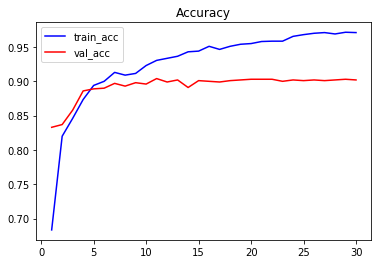

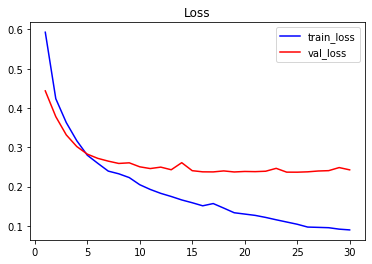

In [7]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='train_loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

In [8]:
# test data로 모델 평가

test_loss, test_acc = model.evaluate(x=test_features, y=test_labels)
print('test_acc : ', test_acc)

1000/1000 [==============================] - 0s 52us/step
test_acc :  0.8880000114440918


**결과 분석**
- 약 90%의 검증 정확도
- 88.8%의 테스트 정확도
- 처음부터 훈련시킨 모델에 비해 훨씬 성능이 좋음
- **dropout을 높은 비율로 사용했지만 overfitting이 일어남**
- **작은 이미지 데이터셋에서는 필수적인 Data Augmentation을 사용하지 않았기 때문**

### 2. Data Augmentation을 사용한 특성 추출

In [17]:
# pretrained vgg16 모델 위에 완전 연결 층 올리기

from keras import models
from keras import layers

model = models.Sequential()

# add()에 그냥 모델 넣으면 됨
model.add(vgg16)

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras import optimizers

# vgg16 pretrained model 가중치 업데이트 동결시키기
# 각 층마다 업데이트 될 가중치 텐서는 2개씩 있음(가중치 행렬, bias 벡터)

print("vgg16 모델 동결 전 업데이트 될 가중치 텐서 수 : ", len(model.trainable_weights))

vgg16.trainable = False

print("vgg16 모델 동결 후 업데이트 될 가중치 텐서 수 : ", len(model.trainable_weights))

# trainable 속성 변경 후 compile()해줘야 변경 사항이 적용됨
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

vgg16 모델 동결 전 업데이트 될 가중치 텐서 수 :  30
vgg16 모델 동결 후 업데이트 될 가중치 텐서 수 :  4


In [19]:
# Augmentation 적용 후 전체 모델 학습

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_generator,
                              validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 15s 146ms/step - loss: 0.6080 - acc: 0.6735 - val_loss: 0.5429 - val_acc: 0.7880
Epoch 2/30
100/100 [==============================] - 14s 143ms/step - loss: 0.4924 - acc: 0.7680 - val_loss: 0.3691 - val_acc: 0.8580
Epoch 3/30
100/100 [==============================] - 14s 140ms/step - loss: 0.4329 - acc: 0.8135 - val_loss: 0.3804 - val_acc: 0.8500
Epoch 4/30
100/100 [==============================] - 14s 142ms/step - loss: 0.4087 - acc: 0.8225 - val_loss: 0.2034 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 14s 140ms/step - loss: 0.3820 - acc: 0.8340 - val_loss: 0.2172 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 14s 141ms/step - loss: 0.3801 - acc: 0.8320 - val_loss: 0.5604 - val_acc: 0.8830
Epoch 7/30
100/100 [==============================] - 14s 140ms/step - loss: 0.3583 - acc: 0.8405 - val_lo

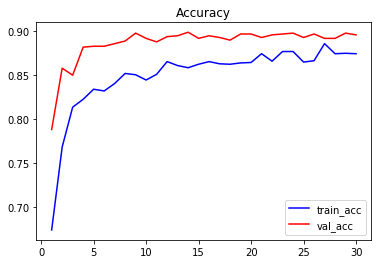

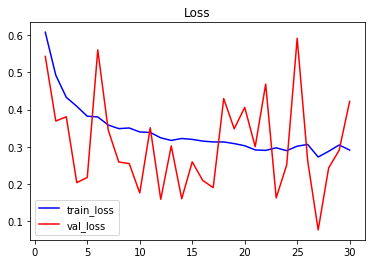

In [20]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='train_loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

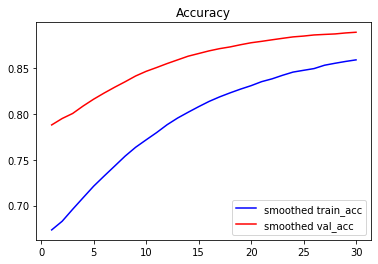

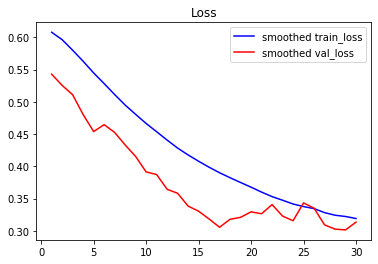

In [21]:
# 그래프의 값 변동이 심하므로 지수이동평균 적용

def smooth_curve(points, factor=0.9):
    smoothed_curve = []
    for point in points:
        if smoothed_curve:
            prev = smoothed_curve[-1]
            smoothed_curve.append(prev*factor + point*(1-factor))
        else:
            smoothed_curve.append(point)
            
    return smoothed_curve


plt.plot(epochs, smooth_curve(acc), 'b', label='smoothed train_acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='smoothed val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'b', label='smoothed train_loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='smoothed val_loss')
plt.title("Loss")
plt.legend()
plt.show()

In [22]:
# test data로 모델 평가

# 검증셋과 테스트셋이 이미지 수가 같아서 val_datagen을 그냥 사용함

test_generator = val_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test_acc : ', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 94ms/step
test_acc :  0.8960000276565552


**결과 분석**
- 처음과 검증 정확도는 비슷(약 90%의 검증 정확도)하지만 **Overfitting이 줄었음**
- 89.6%의 테스트 정확도(약간 상승함)
- **소규모 데이터셋에서는 항상 Augmentation을 적용하자!**

## 5.3.2 미세 조정 (Fine Tuning)

### 미세조정
- 미세 조정(fine-tuning)은 특성 추출(feature extraction)에서 동결 시켰던 **합성곱 기반층의 상위 층 몇개도 완전 연결 층과 함께 동결 해제해 학습시키는 방법**

- pretrained network를 조금 더 조정하기 때문에 미세조정이라고 함


### 미세 조정하는 단계
1. pretrained network 위에 우리가 원하는 새로운 네트워크(완전 연결 층)를 추가
2. pretrained network를 동결시킴
3. 우리가 추가한 새로운 네트워크(완전 연결 층)만 학습
4. 동결시킨 pretrained network의 학습시킬 상위 층 몇개만 동결 해제
5. 동결 해제 한 층과 새로운 네트워크(완전 연결 층)을 함께 학습


***반드시 완전 연결 층을 먼저 학습시킨 후(1~3단계) 동결 해제한 몇개 층을 학습시켜야 함***

### 미세 조정 시 완전 연결 층을 먼저 학습시키는 이유
- 완전 연결 층(분류기)이 먼저 학습되지 않으면 미세 조정될 층에 너무 큰 오차 신호가 전파되며 이는 **미세 조정될 층이 사전에 학습한 표현들을 망가뜨리게 됨**



In [31]:
# 앞에서 feature extraction 후 Data Augmentation 적용해 학습시킨 모델 사용
# 여기서는 최상위 층 3개만 동결 해제해 학습시킴

print("미세조정 층 동결 전 업데이트 될 가중치 텐서 수 : ", len(model.trainable_weights))

# 중요!!!!!!
# 반드시 아까 False한거 다시 True로 만든 다음에 4개 레이어 빼고 False로하기!!!
# 아까 False한거 그대로 하고 안에 4개 레이어만 True로 하면 
# vgg16.trainable값이 False로 이미 되어있어서 미세 조정 층 학습안됨
#
# 반드시 len(model.trainable_weights) 출력 해서 총 가중치 텐서 수 확인하기!!!
#

vgg16.trainable = True

for layer in vgg16.layers[:-4]:
    layer.trainable = False


for layer in vgg16.layers:
    print(layer, layer.trainable)
    

print("미세조정 층 동결 후 업데이트 될 가중치 텐서 수 : ", len(model.trainable_weights))

미세조정 층 동결 전 업데이트 될 가중치 텐서 수 :  4
<keras.engine.input_layer.InputLayer object at 0x7f4eccddbd90> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec3a919d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec3a91b50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4ec3940910> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec39723d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec3900950> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4ec3900c50> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec3915a50> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec3927ad0> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec393ac50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4ec38ce5d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec38e0890> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec38efd10> False
<keras.layers.convolutional.Conv2D object at 0x7f4ec38fc890> False
<keras.layers.pooling.MaxPo

### 미세 조정 하는 층의 수가 적은 이유
- 합성곱 기반 층의 하위 층으로 갈수록 더 일반적이고 재사용 가능한 특성들을 인코딩함
- 합성곱 기반 층의 상위 층으로 갈수록 더 고수준에 특화된 특성을 인코딩함


- **새로운 문제에 재사용 하도록 수정이 필요한 것은 고수준의 구체적인 특성인 경우가 많으므로** 일반적인 경우 최상위 몇개 층만 미세조정함
- **많은 층을 미세조정 시 훈련해야 할 파라미터가 많아지며 훈련해야 할 파라미터가 많을 수록 Overfitting 될 위험이 커지기 때문**에 작은 데이터셋으로 훈련하는 경우 일반적으로 많은 층을 미세조정하지 않음

In [32]:
# 학습률을 낮춘 RMSprop을 사용

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

### 미세 조정 시 학습률을 작게 사용하는 이유
- 미세 조정할 층에 이미 학습된 표현들을 조금씩 수정하기 위해서

In [33]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=val_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 17s 167ms/step - loss: 0.2901 - acc: 0.8755 - val_loss: 0.2286 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 17s 166ms/step - loss: 0.2514 - acc: 0.8925 - val_loss: 0.2296 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 16s 165ms/step - loss: 0.2347 - acc: 0.9030 - val_loss: 0.0367 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 16s 162ms/step - loss: 0.2331 - acc: 0.9050 - val_loss: 0.2232 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 16s 164ms/step - loss: 0.2139 - acc: 0.9125 - val_loss: 0.1234 - val_acc: 0.9180
Epoch 6/100
100/100 [==============================] - 16s 165ms/step - loss: 0.1948 - acc: 0.9185 - val_loss: 0.0037 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1731 - acc: 0.9285 - val_loss: 0.5403 - val_acc: 0.9350
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0319 - acc: 0.9905 - val_loss: 0.1874 - val_acc: 0.9290
Epoch 62/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0308 - acc: 0.9905 - val_loss: 0.6482 - val_acc: 0.9380
Epoch 63/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0316 - acc: 0.9870 - val_loss: 0.2550 - val_acc: 0.9390
Epoch 64/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0269 - acc: 0.9910 - val_loss: 0.0264 - val_acc: 0.9380
Epoch 65/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0273 - acc: 0.9910 - val_loss: 0.6453 - val_acc: 0.9390
Epoch 66/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0360 - acc: 0.9895 - val_loss: 0.1569 - val_acc: 0.9300
Epoch 67/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0376 - acc: 0.9840 - val_loss: 0.1749 - val_acc: 0.9220
Epoch 68/100
100/100 [===================

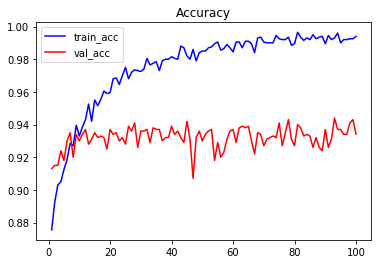

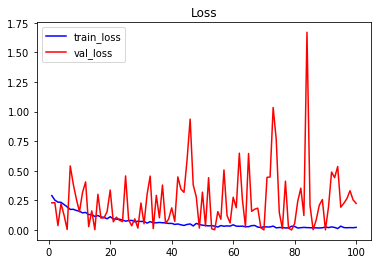

In [34]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='train_loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

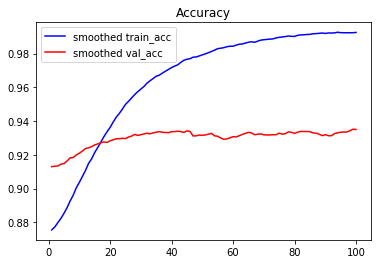

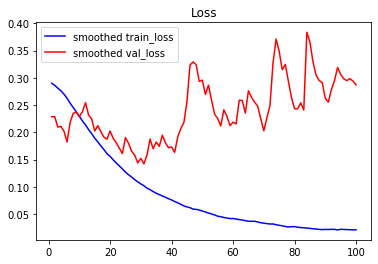

In [35]:
# 그래프의 값 변동이 심하므로 지수이동평균 적용

def smooth_curve(points, factor=0.9):
    smoothed_curve = []
    for point in points:
        if smoothed_curve:
            prev = smoothed_curve[-1]
            smoothed_curve.append(prev*factor + point*(1-factor))
        else:
            smoothed_curve.append(point)
            
    return smoothed_curve


plt.plot(epochs, smooth_curve(acc), 'b', label='smoothed train_acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='smoothed val_acc')
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'b', label='smoothed train_loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='smoothed val_loss')
plt.title("Loss")
plt.legend()
plt.show()

In [36]:
# test data로 모델 평가

# 검증셋과 테스트셋이 이미지 수가 같아서 val_datagen을 그냥 사용함

test_generator = val_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test_acc : ', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 96ms/step
test_acc :  0.9430000185966492


**결과 분석**
- 검증 정확도가 더 상승하였음(94%에 가까워짐)
- 94%의 테스트 정확도(훨씬 성능이 좋아짐)
- 손실은 향상을 얻지못함(더 악화됨)


### 손실이 감소되지 않았는데(오히려 증가) 정확도가 좋아진 이유
- 그래프는 개별 손실 값들의 평균을 나타낸 것
- 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아님
- **모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있음**
    - 4.5절의 내용처럼 **정확도를 직접 최적화는 불가능하고 손실함수를 최적화하기 때문**

### 정리

- Convnet은 컴퓨터 비전에서 가장 뛰어난 모델
- **작은 데이터셋**에서는 Overfitting이 가장 큰 문제
    - **Data Augmetation이 Overfitting 막기 위한 가장 좋은 방법**
    - **Feature Extraction** 방식으로 pretrained network를 재사용 할 수 있음
    - **Fine Tuning**을 통해 Feature Extraction보다 더 성능을 끌어올릴 수 있음